In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius, BetaGaussianQuad

In [2]:
df_train_all = pd.read_csv('../data/cars2010.csv')
df_test_all = pd.read_csv('../data/cars2011.csv')
df_conf_all = pd.read_csv('../data/cars2011.csv')

In [3]:
# df_train_all

In [4]:
df_train = df_train_all[['FE', 'EngDispl']].copy()
df_test = df_test_all[['FE', 'EngDispl']].copy()
df_conf = df_conf_all[['FE', 'EngDispl']].copy()

In [5]:
# df_train

In [16]:
y, X = dmatrices('FE ~ EngDispl', data=df_train, return_type='dataframe')
y_test, X_test = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')
y_conf, X_conf = dmatrices('FE ~ EngDispl', data=df_test, return_type='dataframe')

In [17]:
# y

In [18]:
# X

In [19]:
# plt.scatter(X.EngDispl, y.FE, marker='.')

In [20]:
# Statistically confirm that the data is(/not) heteroscedastic

ols = sm.OLS(y, X)
ols_result = ols.fit()

In [21]:
# residuals of a LM are dependent on X
# plt.scatter(X.EngDispl, ols_result.resid)

In [22]:
# statistical tests confirm this:
het_white(ols_result.resid, X)

(117.7420093723202,
 2.707992895937063e-26,
 65.69933201376779,
 1.1000038748270134e-27)

In [23]:
het_breuschpagan(ols_result.resid, X, robust=False)

(18.460909072394315,
 1.7342523218751654e-05,
 7.9669749301300685,
 0.004849291991016873)

In [24]:
torch.set_default_dtype(torch.double)

In [25]:
X_train = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_train = torch.from_numpy(y.to_numpy()).squeeze()

X_test = torch.from_numpy(X_test.to_numpy())[:, 1].unsqueeze(-1)
y_test = torch.from_numpy(y_test.to_numpy()).squeeze()

X_conf = torch.from_numpy(X_conf.to_numpy())[:, 1].unsqueeze(-1)
y_conf = torch.from_numpy(y_conf.to_numpy()).squeeze()

In [26]:
# X_torch

In [27]:
# n_test = int(.1 * len(X_torch))
# X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
# y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [28]:
# normalize inputs
mu = X_train.mean(dim=0)
std = torch.norm(X_train - mu, dim=0)
# mu
# # std

In [29]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
# X_torch = (X_torch - mu) / std

In [72]:
X_train[:200,:].shape

torch.Size([200, 1])

In [73]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_train.min(), X_train.max() + .1, len(X_train)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a

def save_for_conf(model):
    alpha = model.alpha
    model.eval()
    
    t_test = torch.linspace(X_test.min(), X_test.max() + .1, len(X_test)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred_test, sigma_sq_test = model(t_test)
        std_pred_test = sigma_sq_test.sqrt()
    
    t_test = t_test.squeeze().numpy()
    y_pred_test = y_pred_test.squeeze().numpy()
    std_pred_test = std_pred_test.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_test = 2*std_pred_test
    else:
        # 100% confidence interval.
        R_test = _radius(1, alpha)
        tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
        a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

    t_conf = torch.linspace(X_conf.min(), X_conf.max() + .1, len(X_conf)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred_conf, sigma_sq_conf = model(t_conf)
        std_pred_conf = sigma_sq_conf.sqrt()
    
    t_conf = t_conf.squeeze().numpy()
    y_pred_conf = y_pred_conf.squeeze().numpy()
    std_pred_conf = std_pred_conf.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_conf = 2*std_pred_conf
    else:
        # 100% confidence interval.
        R_conf = _radius(1, alpha)
        tau_conf = (-R_conf**2)/2 * (std_pred_conf**2) ** (-(alpha-1) / (alpha+1))
        a_conf = np.sqrt(-2 * tau_conf * std_pred_conf**2)
    return y_test, y_pred_test, a_test, y_conf, y_pred_conf, a_conf
    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
    ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    # ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])

In [74]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianQuad(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.lin.weight.data, "b", bl_model.lin.bias.data)

R2 train 0.531 test 0.543
w tensor([[-230.5180]]) b tensor([16.5669])


In [75]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    for seed in [42, 43, ]: #44, 45, 46
        torch.manual_seed(seed)
        model = BetaGaussianQuad(input_size=1, uncertainty=True, heteroscedastic=True, alpha=alpha)
        
        model.lin.weight.data[:] = bl_model.lin.weight
        model.lin.bias.data[:] = bl_model.lin.bias
        model.quad.weight.data[:] = bl_model.quad.weight
        model.quad.bias.data[:] = bl_model.quad.bias
        optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
        
        for epoch in range(n_epochs):
            
            def closure():
                optimizer.zero_grad()
                model.train()
                loss = model.loss(X_train, y_train)
                loss.backward()
                return loss
            
            optimizer.step(closure)
                
        # evaluate R^2
        model.eval()
        y_pred_train = model.predict(X_train).detach().numpy()
        y_pred_test = model.predict(X_test).detach().numpy()
    
        r2 = "R2 train {:.3f} test {:.3f}".format(
            r2_score(y_pred_train, y_train.numpy()),
            r2_score(y_pred_test, y_test.numpy()))
    
        results.append((alpha, save_for_plot(model), r2)) #save_for_plot(model),
        np.savetxt(f"{alpha}_{seed}_{r2}.csv", save_for_conf(model), delimiter=",")


In [76]:
len(results[3][1][2])

1107

Text(0.5, 0, 'Standardized county population')

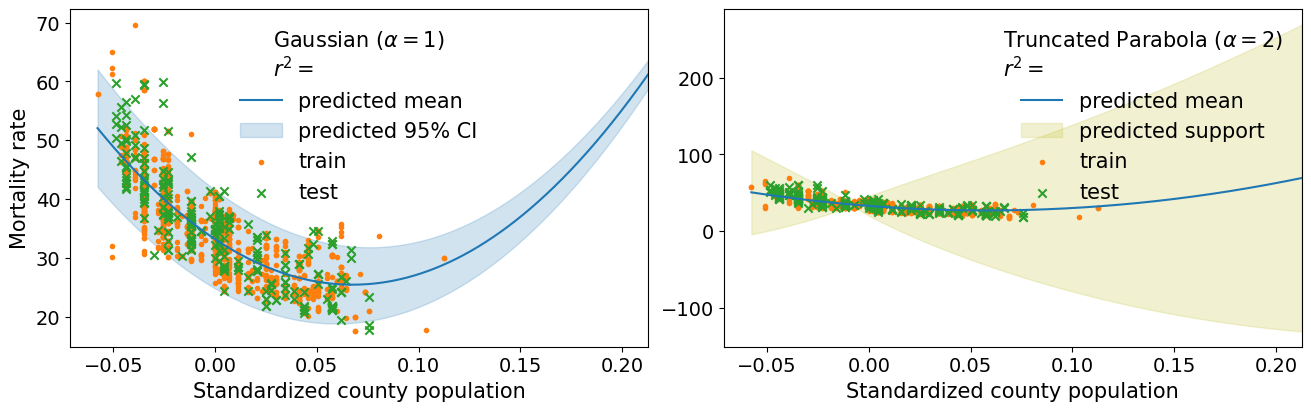

In [77]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=$", fontsize=15)
ax_gauss.set_ylabel("Mortality rate", fontsize=15)
ax_gauss.set_xlabel("Standardized county population", fontsize=15)
ax_tp.set_xlabel("Standardized county population", fontsize=15)
# plt.savefig("heteroscedastic.pdf")